# 01 Daily - Resample and Interpolate Time Series Data

In [1]:
# uploading package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# visual formating the graph
plt.style.use(['seaborn-whitegrid'])
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plt.rcParams['font.family'] = 'cambria'

In [3]:
# parse the date format
def parser(x):
    return pd.to_datetime(x, format='%m-%Y')+pd.tseries.offsets.MonthEnd(1)

In [4]:
# read dataset
series =  pd.read_csv('01-01 TNGMb-UnivariateData.csv', 
                      header=0, 
                      index_col=0, 
                      parse_dates = [0], 
                      date_parser = parser)

In [5]:
print('Dimensi dataframe  :',series.shape)
print('--------------------------------------------------------')
series.head()

Dimensi dataframe  : (72, 1)
--------------------------------------------------------


,#Pengunjung
Bulan,
2013-01-31,2084
2013-02-28,1537
2013-03-31,867
2013-04-30,2158
2013-05-31,1810


Visualisasi Dataset
--------------------------------------------------------


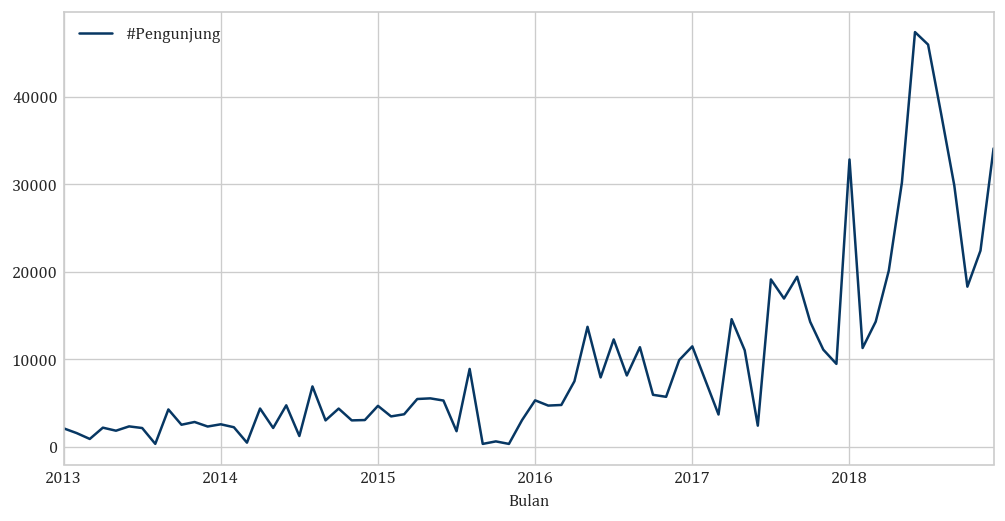

In [6]:
print('Visualisasi Dataset')
print('--------------------------------------------------------')
series.plot(color='#073763')

In [7]:
# make copy the real series
real_series = pd.DataFrame()
real_series = series

In [8]:
def determine_the_index(series):
    start_date = series.index.min() - pd.DateOffset(day=1)
    end_date = series.index.max() + pd.DateOffset(day=31)
    dates = pd.date_range(start_date, end_date, freq='D')
    dates.name = 'date'
    
    return dates

In [9]:
dates = determine_the_index(series)
series = series.reindex(dates, method='bfill')

In [10]:
series.head()

,#Pengunjung
date,
2013-01-01,2084
2013-01-02,2084
2013-01-03,2084
2013-01-04,2084
2013-01-05,2084


In [11]:
def decomposition_data_point(series,real_series):

    decomposition = pd.DataFrame()
    decomposition['date'] = real_series.index.values
    months = [d.strftime('%Y-%m') for d in real_series.index]
    Each_Month = list()
    for m in months:
        rows = series[m].count()
        Each_Month.append(rows.values)
    
    decomposition['#Day'] = pd.DataFrame(Each_Month)
    decomposition = decomposition.set_index('date')
    decomposition['#Visitors'] = real_series['#Pengunjung'].values
    decomposition['#VisitorPerDay'] = decomposition['#Visitors']/decomposition['#Day']
    
    return decomposition

In [12]:
data_point=decomposition_data_point(series,real_series)

Visualisasi data point baru
--------------------------------------------------------


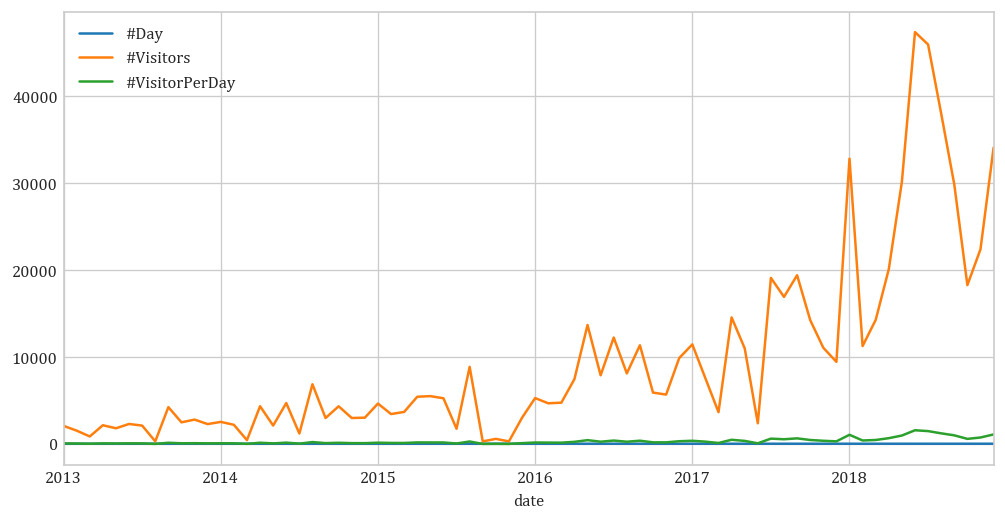

In [13]:
print('Visualisasi data point baru')
print('--------------------------------------------------------')
data_point.plot()

In [14]:
print(data_point.shape)
data_point.head()

(72, 3)


,#Day,#Visitors,#VisitorPerDay
date,,,
2013-01-31,31,2084,67.225806
2013-02-28,28,1537,54.892857
2013-03-31,31,867,27.967742
2013-04-30,30,2158,71.933333
2013-05-31,31,1810,58.387097


In [15]:
def decomposition_interval(data_point,dates):
    data_point = data_point.reindex(dates, method='bfill')
    months_nan = [d.strftime('%Y-%m') for d in data_point.index]
    min_date = list()
    for i, m in enumerate(months_nan):
        rows = data_point[m].index.date.min()
        min_date.append(rows)
    min_date = pd.to_datetime(min_date)
    data_point[data_point.index > min_date] = np.nan
    
    return data_point

In [16]:
interval = decomposition_interval(data_point,dates)
print(interval.shape)
interval['2018-12'].head()

(2191, 3)


,#Day,#Visitors,#VisitorPerDay
date,,,
2018-12-01,31.0,34096.0,1099.870968
2018-12-02,NaN,NaN,NaN
2018-12-03,NaN,NaN,NaN
2018-12-04,NaN,NaN,NaN
2018-12-05,NaN,NaN,NaN


In [17]:
def data_point_time_space(data_point):

    max_month = data_point.index.month.max()
    max_year = data_point.index.year.max()
    max_date = data_point.index.date.max()
    value_latest_day = data_point[(data_point.index.year == max_year) & (data_point.index.month == max_month)].first('D').values
    data_point.loc[max_date] = value_latest_day

    second_latest_month = data_point[(data_point.index.year == max_year) & (data_point.index.month == max_month)].first('D').values
    latest_month = data_point[(data_point.index.year == max_year) & (data_point.index.month == max_month-1)].first('D').values

    average_latest = (latest_month+second_latest_month)/2

    latest_month_1stValue = data_point[(data_point.index.year == max_year) & (data_point.index.month == max_month)].first('D').index.date
    data_point.loc[latest_month_1stValue] = average_latest
    
    return data_point

In [18]:
data_point_nan=data_point_time_space(interval)

In [19]:
interval['2018-12'].head()

,#Day,#Visitors,#VisitorPerDay
date,,,
2018-12-01,30.5,28251.0,923.368817
2018-12-02,NaN,NaN,NaN
2018-12-03,NaN,NaN,NaN
2018-12-04,NaN,NaN,NaN
2018-12-05,NaN,NaN,NaN


In [20]:
data_point_nan=data_point_nan.drop(columns=['#Day','#Visitors'])
UpSampling = data_point_nan.interpolate(method='cubic')

In [21]:
UpSampling.head()

,#VisitorPerDay
date,
2013-01-01,67.225806
2013-01-02,66.834750
2013-01-03,66.434623
2013-01-04,66.034495
2013-01-05,65.634368


In [22]:
UpSampling[UpSampling<0]= UpSampling[UpSampling<0]*-1

In [23]:
pd.DataFrame(UpSampling['#VisitorPerDay']).describe()

,#VisitorPerDay
count,2191.000000
mean,318.835100
std,338.416216
min,9.774194
25%,90.646949
50%,176.013794
75%,406.351114
max,1579.933333


In [24]:
UpSampling['#VisitorPerDay'] = round(UpSampling['#VisitorPerDay']).astype(int)
pd.DataFrame(UpSampling['#VisitorPerDay']).describe()

,#VisitorPerDay
count,2191.000000
mean,318.834779
std,338.410508
min,10.000000
25%,91.000000
50%,176.000000
75%,406.500000
max,1580.000000


In [25]:
real_series.describe()

,#Pengunjung
count,72.000000
mean,9558.736111
std,10717.156334
min,300.000000
25%,2466.250000
50%,5271.500000
75%,11654.750000
max,47398.000000


In [26]:
# UpSampling.to_csv('03-03 TNGMb-Daily.csv',index=True)

<function matplotlib.pyplot.show(*args, **kw)>

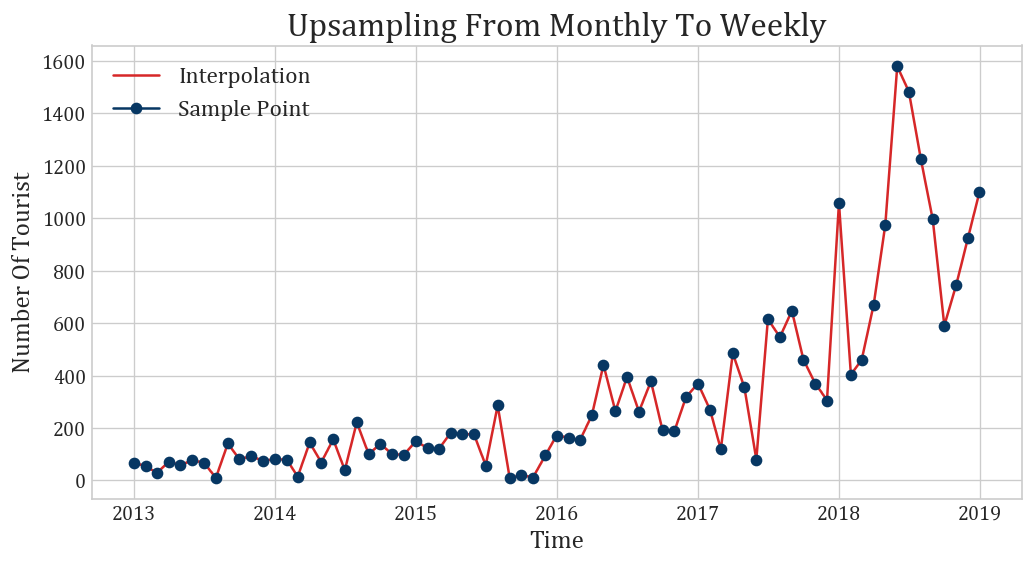

In [27]:
plt.plot(UpSampling,label='Interpolation',color='tab:red')
plt.plot(data_point_nan,label='Sample Point',marker='o',color='#073763')
plt.legend(loc='best',fontsize=14)
plt.ylabel('Number Of Tourist',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title("Upsampling From Monthly To Weekly", fontsize=20)
plt.show